In [12]:
# validate_project2.py

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

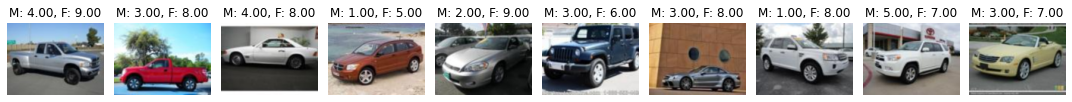

In [13]:
def visualize_with_scores(images, conditions, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i, ax in enumerate(axes):
        original_img = transforms.ToPILImage()(images[i].cpu())
        original_img = original_img.resize((128, 96))  # Resize to 128x96
        ax.imshow(original_img)
        ax.set_title(f"M: {conditions[i, 0]:.2f}, F: {conditions[i, 1]:.2f}")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

# Load the saved images
saved_images = torch.load('images.pth')
saved_conditions = torch.load('embeddings.pth')[:, -2:]  # Extract the conditions from the embeddings

# Visualize with scores
visualize_with_scores(saved_images[:10], saved_conditions[:10])

In [14]:
class CVAE_ResNet18_DualEmbedding(nn.Module):
    def __init__(self, conditional_dim=2, latent_dim=512, debug=False):
        super(CVAE_ResNet18_DualEmbedding, self).__init__()
        self.debug = debug
        self.bn1 = nn.BatchNorm2d(256)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(32)
        
        self.conditional_dim = conditional_dim
        self.latent_dim = latent_dim
        
        # Load the ResNet18 model with pretrained weights
        self.resnet18 = models.resnet18(weights='DEFAULT')
        
        # Extract the feature layers
        self.features = nn.Sequential(*list(self.resnet18.children())[:-1])
        
        # Encoder layers
        self.fc_mu = nn.Linear(512 + self.conditional_dim, self.latent_dim)
        self.fc_logvar = nn.Linear(512 + self.conditional_dim, self.latent_dim)
        
        # Decoder layers
        self.decoder_input = nn.Linear(self.latent_dim + self.conditional_dim, 512 * 7 * 7)
        self.deconv1 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.deconv4 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.deconv5 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)

    def encode(self, x, c):
        # Extract features using ResNet18
        x = self.features(x)
        if self.debug: print(f"After ResNet18 features extraction: {x.shape}")
        x = x.view(x.size(0), 512)  # only flatten the spatial dimensions
        if self.debug: print(f"After reshaping: {x.shape}")
        
        # Concatenate condition vectors
        x = torch.cat([x, c], dim=1)
        if self.debug: print(f"After concatenating with condition vector: {x.shape}")
        
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z, c):
        # Concatenate z with condition vectors
        z = torch.cat([z, c], dim=1)
        if self.debug: print(f"After concatenating z with condition vector: {z.shape}")

        x = F.relu(self.decoder_input(z))
        x = x.view(x.size(0), 512, 7, 7)  # reshape to (batch, channels, height, width)
        x = F.relu(self.bn1(self.deconv1(x)))
        x = F.relu(self.bn2(self.deconv2(x)))
        x = F.relu(self.bn3(self.deconv3(x)))
        x = F.relu(self.bn4(self.deconv4(x)))
        x = torch.sigmoid(self.deconv5(x))

        return x
    
    def forward(self, x, c):
        if self.debug: print(f"Input image shape: {x.shape}, Condition shape: {c.shape}")
        mu, logvar = self.encode(x, c)
        if self.debug: print(f"Encoding outputs - mu: {mu.shape}, logvar: {logvar.shape}")
        z = self.reparameterize(mu, logvar)
        if self.debug: print(f"Latent representation z shape: {z.shape}")
        recon_x = self.decode(z, c)
        return recon_x, mu, logvar

# Initialize model
cvae = CVAE_ResNet18_DualEmbedding(conditional_dim=2, latent_dim=512, debug=True).to(device)
cvae

CVAE_ResNet18_DualEmbedding(
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (resnet18): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2)

In [15]:
def compare_state_dicts(model_state_dict, loaded_state_dict):
    model_keys = set(model_state_dict.keys())
    loaded_keys = set(loaded_state_dict.keys())
    
    # Check for keys in the model
    missing_in_loaded = model_keys - loaded_keys
    if missing_in_loaded:
        print("Missing in loaded state_dict:")
        for key in missing_in_loaded:
            print(key)
        print("\n")
    
    # Check for keys in the loaded state_dict
    extra_in_loaded = loaded_keys - model_keys
    if extra_in_loaded:
        print("Extra keys in loaded state_dict:")
        for key in extra_in_loaded:
            print(key)
        print("\n")
    
    # Check for discrepancies in tensor shapes
    for key in model_keys.intersection(loaded_keys):
        model_shape = model_state_dict[key].shape
        loaded_shape = loaded_state_dict[key].shape
        if model_shape != loaded_shape:
            print(f"Shape mismatch for key '{key}': Model - {model_shape}, Loaded - {loaded_shape}")
            
    if not missing_in_loaded and not extra_in_loaded:
        print("Keys match between the model's state_dict and the loaded state_dict.")
        

# Instantiate the model
model_instance = CVAE_ResNet18_DualEmbedding(conditional_dim=2, latent_dim=512, debug=True).to(device)

# Load the saved state_dict
saved_weights_path = "best_conv_model_weights.pth"
loaded_state_dict = torch.load(saved_weights_path, map_location=device)

# Compare the state_dicts
compare_state_dicts(model_instance.state_dict(), loaded_state_dict)

Keys match between the model's state_dict and the loaded state_dict.


Embeddings shape: torch.Size([10, 514])
Images shape: torch.Size([10, 3, 224, 224])

Shape checks before decoding:

Embeddings_data (z): torch.Size([10, 512])
Conditions (c): torch.Size([10, 2])
Concatenated input: torch.Size([10, 514])
Expected input shape for the decoder's linear layer: 514
After concatenating z with condition vector: torch.Size([10, 514])
Predicted images shape: torch.Size([10, 3, 224, 224])


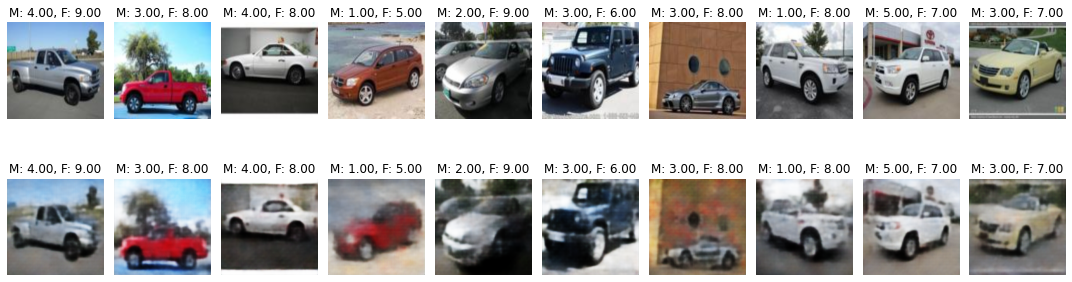

Model loaded and tested successfully.


In [36]:
# Load the model
def load_my_models() -> nn.Module:
    # Initialize model
    model = CVAE_ResNet18_DualEmbedding(conditional_dim=2, latent_dim=512, debug=True).to(device)
    
    # Load weights
    model.load_state_dict(torch.load("best_conv_model_weights.pth", map_location=device))

    return model


def visualize_images(saved_images, predicted_images, conditions, num_images=10):
    fig, axes = plt.subplots(2, num_images, figsize=(15, 5))
    for i in range(num_images):
        # Original (saved) image
        ax = axes[0, i]
        ax.imshow(saved_images[i].permute(1, 2, 0).cpu().numpy())
        ax.set_title(f"M: {conditions[i, 0]:.2f}, F: {conditions[i, 1]:.2f}")
        ax.axis("off")

        # Predicted image
        ax = axes[1, i]
        ax.imshow(predicted_images[i].detach().permute(1, 2, 0).cpu().numpy())
        ax.set_title(f"M: {conditions[i, 0]:.2f}, F: {conditions[i, 1]:.2f}")
        ax.axis("off")
    plt.tight_layout()
    plt.show()
    

def test_my_model():
    model = load_my_models()
    model = model.to(device)
    model.eval()  # Set the model to evaluation mode

    # Load saved embeddings and images
    embeddings = torch.load('embeddings.pth')
    images = torch.load('images.pth').to(device)
    
    print("Embeddings shape:", embeddings.shape)
    print("Images shape:", images.shape)
        
    embeddings_data, conditions = embeddings[:, :-2], embeddings[:, -2:]
    
    # Debug: print out conditions to watch the scores
    # print("\nConditions for first 10 samples:")
    # for i, cond in enumerate(conditions[:10]):
    #     print(f"Sample {i}: Moira: {cond[0]:.2f}, Ferdinando: {cond[1]:.2f}")
    
    with torch.no_grad():
        # Directly decode the embeddings without passing through the encoder
        
        # Debug checks for shapes
        print("\nShape checks before decoding:\n")
        print(f"Embeddings_data (z): {embeddings_data.shape}")
        print(f"Conditions (c): {conditions.shape}")
        
        # Concatenate and check shape
        concatenated_input = torch.cat([embeddings_data, conditions], dim=1)
        print(f"Concatenated input: {concatenated_input.shape}")
        
        # Check the expected input shape of the decoder's linear layer
        expected_shape = model.decoder_input.weight.shape[1]
        print(f"Expected input shape for the decoder's linear layer: {expected_shape}")
        
        # Proceed with decoding
        pred_images = model.decode(embeddings_data.to(device), conditions.to(device))

    print("Predicted images shape:", pred_images.shape)
    
    # Visualize the images
    visualize_images(images[:10], pred_images[:10], conditions[:10])  # Pass the conditions
    
    return torch.allclose(pred_images, images, atol=1)

if __name__ == '__main__':
    assert test_my_model(), "Model loading or prediction failed."
    print("Model loaded and tested successfully.")